In [1]:
import re
import glob
import sys
import pandas as pd
import numpy as np
import cv2
import pickle
from sklearn.metrics import *

%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
def plot_detections(img_file, detection):
    img = cv2.imread(img_file)[...,::-1].astype(np.uint8).copy() 
    for d in detection:
        score = '%.2f' % d[1]
        (xc, yc, w, h) = map(int, d[2])
        img = cv2.rectangle(img,(xc-w//2,yc-h//2),(xc+w//2,yc+w//2),(0,255,0),3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        img = cv2.putText(img,score,(xc-w//2,yc-h//2-10), font, 1,(255,0,0),3,cv2.LINE_AA)
    plt.imshow(img)

In [2]:
plt.rcParams["figure.figsize"] = (20,12)

def extract_stats(fn, seq_re):
    seq = re.search(seq_re, fn).group(1)
    out = open(fn, 'r').read()
    try:
        return dict(
            ap=re.search("mean average precision \(mAP\) = ([\.\d]+)", out).group(1),
            precision=re.search("precision = ([\.\d]+)", out).group(1),
            recall=re.search("recall = ([\.\d]+)", out).group(1),
            f1=re.search("F1-score = ([\.\d]+)", out).group(1),
            seq=seq,
        )
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return None


def batch_perf(batch, seq_re="yolov2-voc_([\d]+).weights.out"):
    stats = []
    for f in glob.glob(batch):
        if extract_stats(f, seq_re):
            stats.append(extract_stats(f, seq_re))
    df = pd.DataFrame(stats, dtype='float')
    return df.set_index('seq').sort_index()

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


seq
5000.0     0.419031
2000.0     0.418875
3300.0     0.418389
23100.0    0.417701
23400.0    0.416190
11700.0    0.414706
20300.0    0.413739
20700.0    0.413436
12900.0    0.412790
22500.0    0.412747
Name: ap, dtype: float64

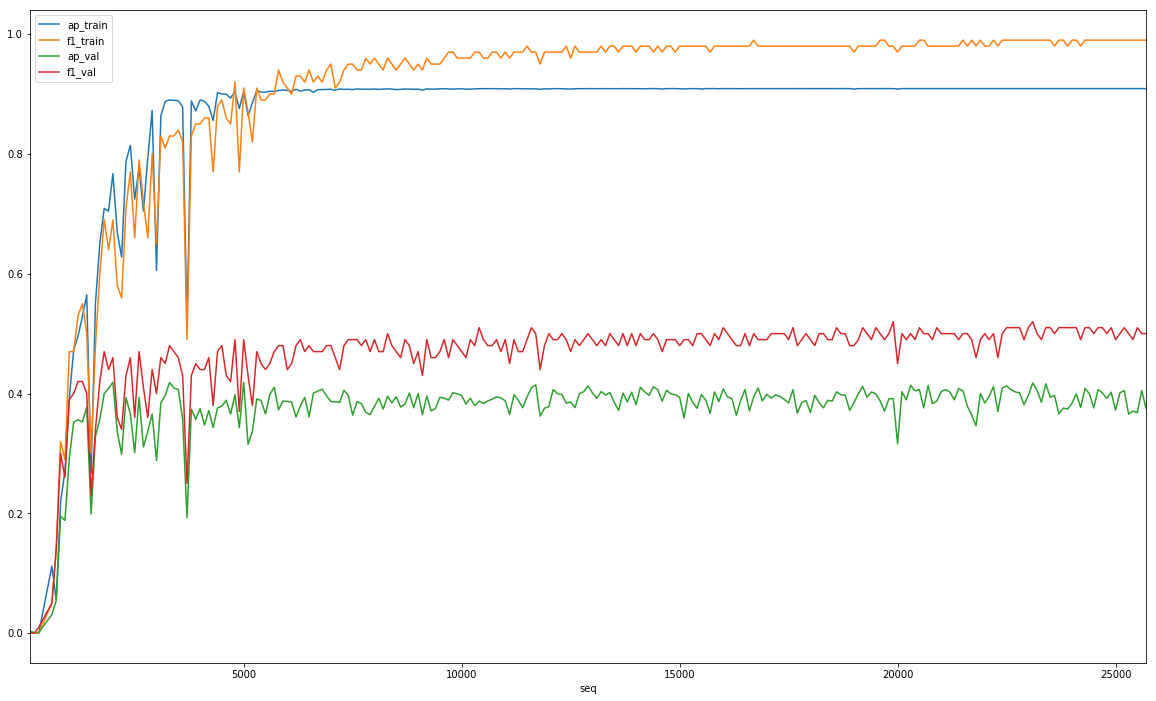

In [52]:
df_train = batch_perf('/mnt/ml-data4/error-analysis/baseline/800.train.out/*.weights.out')
df_val = batch_perf('/mnt/ml-data4/error-analysis/baseline/800.out/*.weights.out')
df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
# df_val[['ap', 'f1']].plot()
df_val.ap.nlargest(10)

In [2]:
plt.rcParams["figure.figsize"] = (12,6)

def extract_stats(fn, seq_re, jpg_path, take): 
    seq = re.search(seq_re, fn).group(1)
    ds = pickle.load( open( fn, "rb" ) )
    if take > 1:
        selected_ds = []
        for subdir in ['false_alert', 'positives', 'negatives']:
            subds = [d for d in ds if subdir in d[0]]
#             selected_ds += subds[:len(subds)//take]
            selected_ds += subds[::take]

        ds = selected_ds
        
    df = pd.DataFrame([[d[0], d[1][0][1], d[1][1][1], d[1][2][1]] for d in ds], columns=['fn', 'p1', 'p2', 'p3'])
#     df['p'] = df.p1 + df.p2 + df.p3
    df['p'] = df.p1
    df.loc[df.p > 1,'p'] = 1
    df['y_true'] = df.fn.str.contains('positives/')
    fpr, tpr, _ = roc_curve(df.y_true, df.p)
    return dict(
        roc=auc(fpr, tpr),
        ratio=df[df.y_true == True].p.sum()/df[df.y_true == False].p.sum(),
        seq=seq,
        df=df,
    )

def batch_perf(batch, seq_re="yolov2-voc_([\d]+).weights.pkl", jpg_path='/mnt/ml-data4/tsd/jpgs/', take=1):
    stats = []
    for f in glob.glob(batch):
#         if extract_stats(f, seq_re, jpg_path, take):
        stats.append(extract_stats(f, seq_re, jpg_path, take))
    df = pd.DataFrame(stats, dtype='float')
    return df.set_index('seq').sort_index()

In [ ]:
# df_1661 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/1661.out/*.pkl')
# df_800 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/800.out/*.pkl')
# df_800_strong = batch_perf('/mnt/ml-data4/error-analysis/strong-samples/800.pos.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
# df_400 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/400.out/*.pkl')
# df_200 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/200.out/*.pkl')
# df_100 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/100.out/*.pkl')
# df_1230 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/1230.out/*.pkl')
# df_2461 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/2461.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
# df_800_neg = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/800_neg.out/*.pkl')
# df_800_neg_1600 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/800_neg_1600.out/*.pkl')
# df_800_neg_6013 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/800_neg_6013.out/*.pkl')
# df_800_neg_6013_2 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/800_neg_6013.out/*.pkl', take=4)
# df_400_neg = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/400_neg.out/*.pkl')
df_3209_pos = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/3209.pos.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df_3209_neg_3000 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/3209.neg_3000.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df_3209_neg_6000 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/3209.neg_6000.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
# df_3209_neg_12000 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/3209.neg_12000.out/*.pkl')
df_3209_neg_32213 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/3209.neg_32213.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df_neg_with_fp = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/3209.neg_with_fp.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df_3209_5200_fp_3000 = batch_perf('/mnt/ml-data4/error-analysis/tsd-val/3209.5200_fp_3000.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
# df_v3 = batch_perf('/mnt/ml-data4/error-analysis/yolov3/3209.neg_32213.out/*.pkl', seq_re='yolov3_([\d]+).weights.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df_3209_strong = batch_perf('/mnt/ml-data4/error-analysis/strong-samples/3209.pos.out/*.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df_3209_grayscale = batch_perf('/mnt/ml-data4/error-analysis/grayscale/3209.pos.out/*.pkl', jpg_path='/mnt/ml-data4/error-analysis/grayscale/val_jpgs')

In [ ]:
# plt.rcParams["figure.figsize"] = (6,5)
# print(df_100.f1.nlargest(10).mean())
# print(df_200.f1.nlargest(10).mean())
# print(df_400.f1.nlargest(3).mean())
# print(df_800.roc.nlargest(3))
# print(df_800.ratio.nlargest(3))
# print(df_800_strong.roc.nlargest(3))
# print(df_800_strong.ratio.nlargest(3))
# print(df_1230.f1.nlargest(10).mean())
# print(df_1661.f1.nlargest(3).mean())
# print(df_2461.roc.nlargest(3))
# print(df_2461.ratio.nlargest(3))
# print(df_3562.f1.nlargest(10).mean())


# print(df_400_neg.f1.nlargest(3).mean())
# print(df_800_neg.roc.nlargest(3))
# print(df_800_neg.ratio.nlargest(3))
# print(df_800_neg_1600.f1.nlargest(3).mean())
# print(df_800_neg_6013.roc.nlargest(3).mean())
# print(df_800_neg_6013.ratio.nlargest(3).mean())
# print(df_800_neg_1600.f1.nlargest(10))
print(df_3209_pos.roc.nlargest(3))
# print(df_3209_pos.ratio.nlargest(3))
print(df_3209_neg_3000.roc.nlargest(3))
# print(df_3209_neg_3000.ratio.nlargest(3))
# print(df_3209_neg_6000.roc.nlargest(3))
# print(df_3209_neg_6000.ratio.nlargest(3))
# print(df_3209_neg_12000.f1.nlargest(3))
print(df_3209_neg_32213.roc.nlargest(3))
# print(df_3209_neg_32213.ratio.nlargest(3))
print(df_neg_with_fp.roc.nlargest(3))
# print(df_neg_with_fp.ratio.nlargest(3))
print(df_3209_5200_fp_3000.roc.nlargest(3))
# print(df_3209_5200_fp_3000.ratio.nlargest(3))
print(df_3209_strong.roc.nlargest(3))
# print(df_3209_strong.ratio.nlargest(3))

# df_400.plot()
# df_800.plot()
# df_800_strong.plot()
# df_800_neg.plot()
# df_1661.plot()
# df_2461.plot()

# df_400_neg.plot()
# df_800_neg.plot()
# df_800_neg_1600.plot()
# df_800_neg_6013.plot()
# df_800_neg_6013_2.plot()
df_3209_pos.plot()
# df_3209_neg_3000.plot()
# df_3209_neg_6000.plot()
# df_3209_neg_12000.plot()
df_3209_neg_32213.plot()
df_neg_with_fp.plot()
# df_3209_5200_fp_3000.plot()
df_3209_strong.plot()

# print(df_v3.roc.nlargest(3))
# print(df_v3.ratio.nlargest(3))
# df_v3.plot()

In [6]:
hpsearch = [[t, batch_perf('/mnt/ml-data4/error-analysis/tsd-val/2461.out/*.pkl', seq_re="yolov2-voc_([\d]+).weights.pkl", thresh=t).f1.nlargest(3)] for t in np.arange(0.33, 0.43, 0.02)]
pd.DataFrame([h[1].iloc[0] for h in hpsearch], index=[h[0] for h in hpsearch]).plot()
hpsearch


KeyboardInterrupt: 

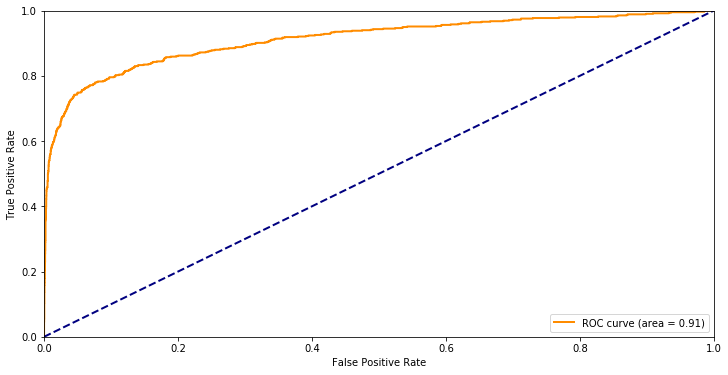

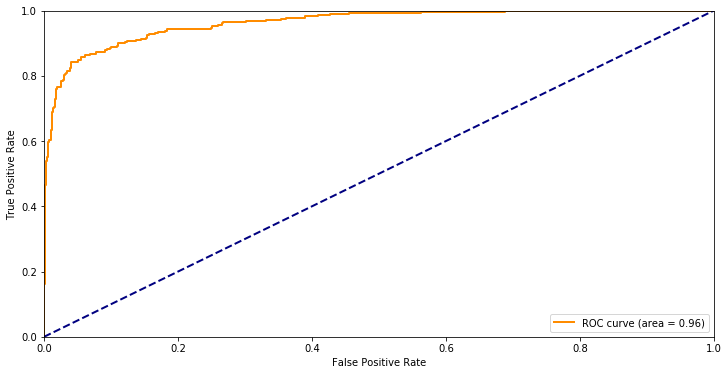

In [9]:

def plot_roc(fn, jpg_path='/mnt/ml-data4/tsd/jpgs/', seq_re="yolov2-voc_([\d]+).weights.pkl"):
#     df = pd.DataFrame([[d[0], d[1][0][1], d[1][1][1], d[1][2][1]] for d in ds], columns=['fn', 'p1', 'p2', 'p3'])
# #     df['p'] = df.p1 + df.p2 + df.p3
#     df['p'] = df.p1
#     df.loc[df.p > 1,'p'] = 1 
#     df['y_true'] = df.fn.str.contains(jpg_path+'positives/')
    df = extract_stats(fn, seq_re, jpg_path, take=1)['df']

    fpr, tpr, _ = roc_curve(df.y_true, df.p)
    test_roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return df
    
# df1 = plot_roc(pickle.load( open('/mnt/ml-data4/error-analysis/tsd-val/3209.5200_fp_3000.out/yolov2-voc_11800.weights.pkl', "rb" )), jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df2 = plot_roc('/mnt/ml-data4/error-analysis/tsd-val/3209.neg_32213.out/yolov2-voc_24000.weights.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')
df1 = plot_roc('/mnt/ml-data4/error-analysis/yolov3/3209.neg_32213.out/yolov3_2600.weights.pkl', seq_re='yolov3_([\d]+).weights.pkl', jpg_path='/mnt/ml-data4/tsd/val_jpgs/')

In [10]:
ds1 = pickle.load( open('/mnt/ml-data4/error-analysis/yolov3/3209.neg_32213.out/yolov3_2600.weights.pkl', "rb"))
ds2 = pickle.load( open('/mnt/ml-data4/error-analysis/tsd-val/3209.neg_32213.out/yolov2-voc_10000.weights.pkl', "rb" ))

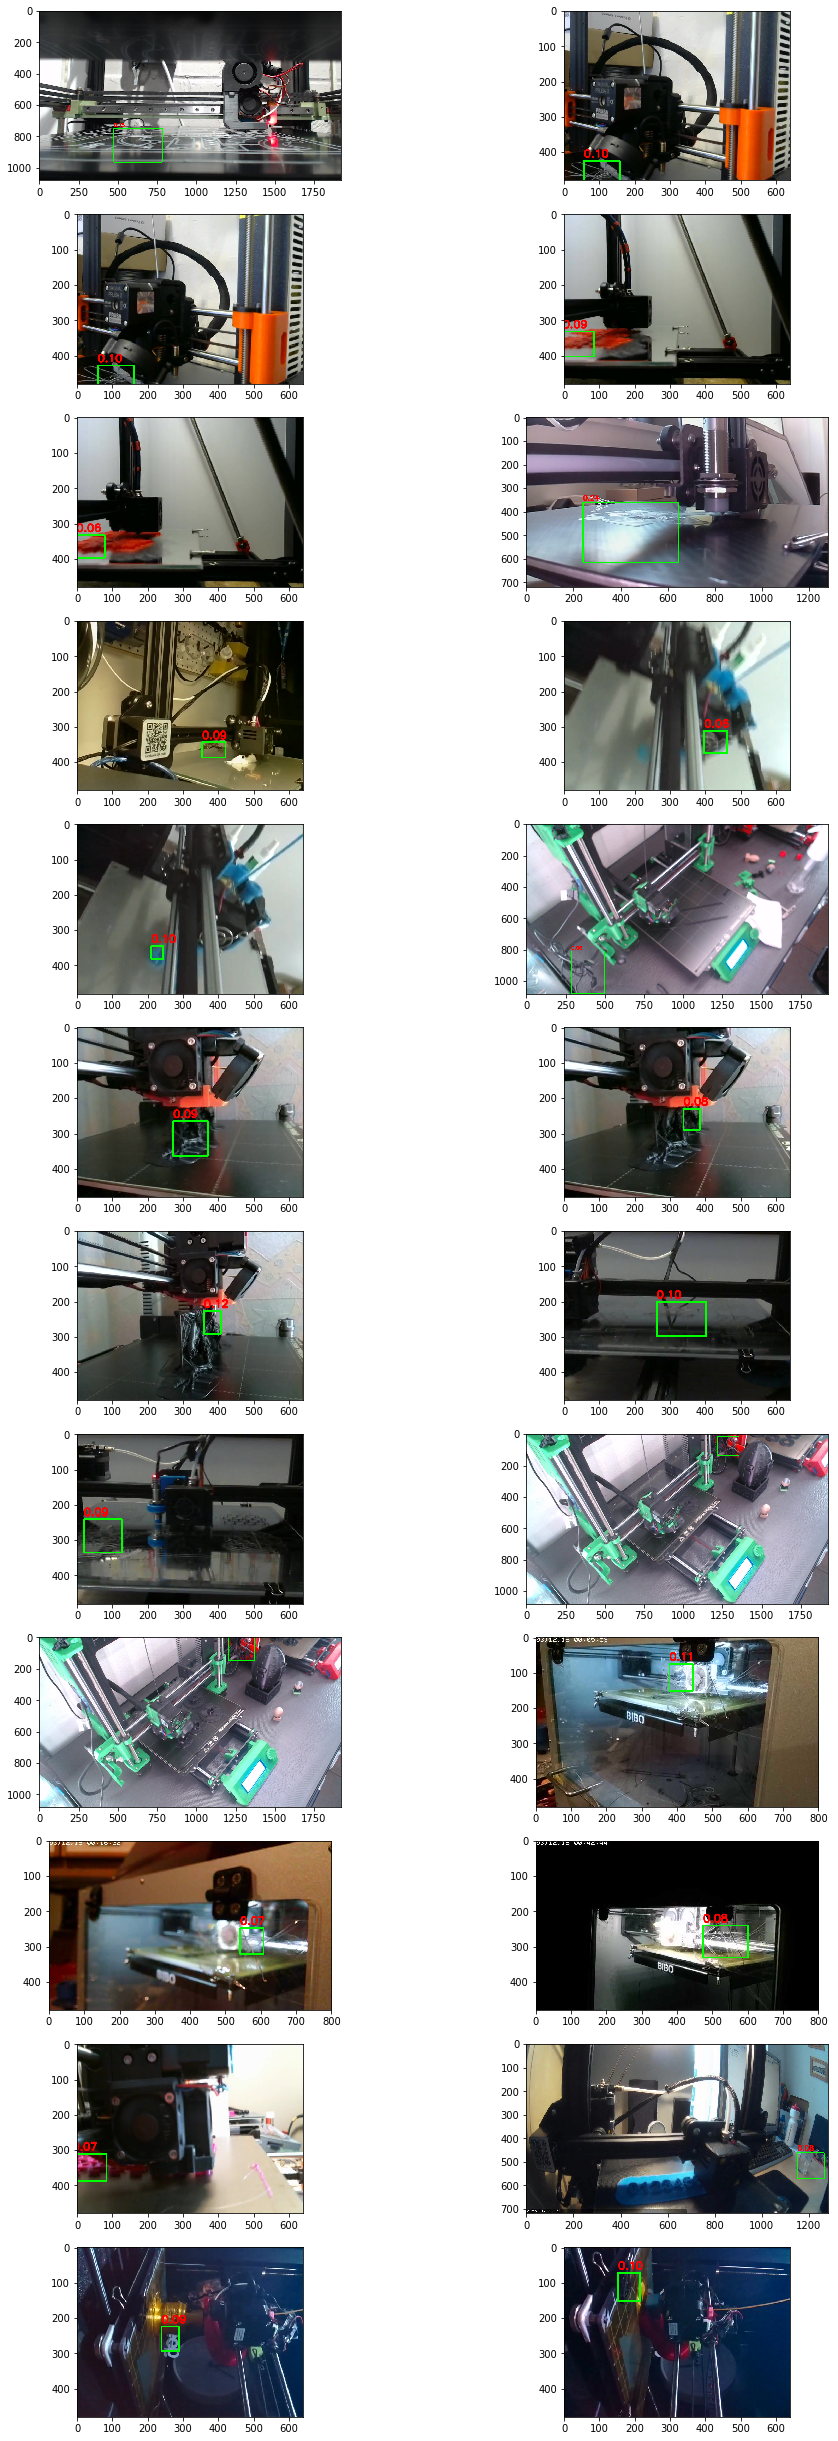

In [13]:
fp2 = df2[(df2.y_true == False) & (df2.p1 > 0.16)].fn
fp1 = df1[(df1.y_true == False) & (df1.p1 > 0.06)].fn

# fp = list(set(fp1) - set(fp2))
fp = fp1
ds = ds1

fig=plt.figure(figsize=(16, 16*len(fp)/8))

i = 1
for fn in fp:
    ax = fig.add_subplot(len(fp)/2+1, 2, i)
    ax.grid(False)
    plot_detections(fn, [d for d in ds if d[0] == fn][0][1][:1])
    i += 1

4.567320659991509
1.8854505949740037
8.584130159295455
114.56756299454719


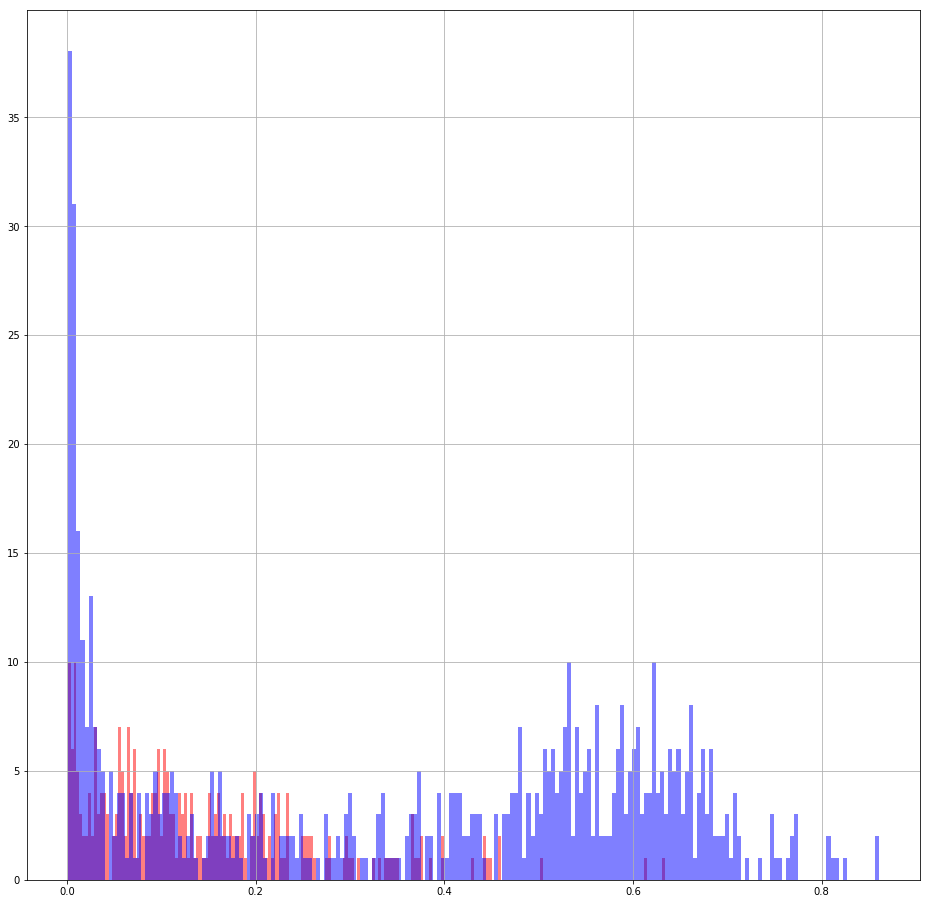

In [15]:
# df1[df1.y_true == False].p1.hist(bins=100, alpha=0.5, color='r')
# df2[df2.y_true == False].p1.hist(bins=100, alpha=0.5, color='b')
plt.figure(figsize=(16, 16))
df1[df1.y_true == True].p1.hist(bins=200, alpha=0.5, color='r')
df2[df2.y_true == True].p1.hist(bins=200, alpha=0.5, color='b')
# plt.figure()
# df1[df1.y_true == False].p1.hist(bins=200, alpha=0.5, color='b')
# df2[df2.y_true == False].p1.hist(bins=200, alpha=0.5, color='r')

print(df1[df1.y_true == True].p1.sum()/df1[df1.y_true == False].p1.sum())
print(df2[df2.y_true == True].p1.sum()/df2[df2.y_true == False].p1.sum())

print(df1[df1.y_true == False].p1.sum())
print(df2[df2.y_true == False].p1.sum())

In [21]:
good = pickle.load( open('/tmp/good.pkl', 'rb'))
fps = [d for d in good if d[1][0][1] > 0.49]
fns = [f[0] for f in fps[:3000]]
with open('/tmp/fp.txt', 'w') as f:
    for item in fns:
        f.write("%s\n" % item)